In [32]:
%matplotlib inline
import sys
import math
import psycopg2
import psycopg2.extras
import numpy as np
from matplotlib import pyplot
from astropy import units
from astropy.coordinates import SkyCoord

In [5]:
dbhost = "decatdb.lbl.gov"
dbname = "desi"
dbuser = "desi"
# dbpasswd = "put right password here"

In [26]:
dbconn = psycopg2.connect( f"dbname='{dbname}' host='{dbhost}' user='{dbuser}' password='{dbpasswd}'",
                         cursor_factory=psycopg2.extras.RealDictCursor )

There are a few tables that are relevant here.  The table `mosthosts.mosthosts` table has all the information from Maayane's CSV file.  Columns include:
- `ra` (degrees)
- `dec` (degrees)
- `snname` (some sort of primary name for the supernova)
- `hemisphere` (north or south)
- `sn_ra` (RA of the supernova this is a possible host for)
- `sn_dec` (dec of the supernova this is a possible host for)
- `sn_z` (redshift (determined how?) of supernova)
- `program` (some indicator of where this supernova came from; multiple things are /-separated)
- `tns_name` (not sure what tns is)
- `iau_name` (IAU name if the SN has one)
- `ptfiptf_name` (probably something from PTF)

In [7]:
# Count number of supernovae and number of distinct supernovae in the table
q = "SELECT COUNT(snname) AS num FROM mosthosts.mosthosts"
cursor = dbconn.cursor()
cursor.execute( q )
row = cursor.fetchone()
print( f'There are {row["num"]} entries in the mosthosts table.' )

q = "SELECT COUNT(DISTINCT snname) AS num FROM mosthosts.mosthosts"
cursor.execute( q )
row = cursor.fetchone()
print( f'There are {row["num"]} distinct supernovae in the mosthosts table.' )

There are 20174 entries in the mosthosts table.
There are 14958 distinct supernovae in the mosthosts table.


(array([3246., 3810., 1576.,  638.,  399.,  256.,  157.,  121.,   86.,
          66.,   53.,   78.,   59.,   85.,   75.,   79.,   75.,   81.,
          71.,   45.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

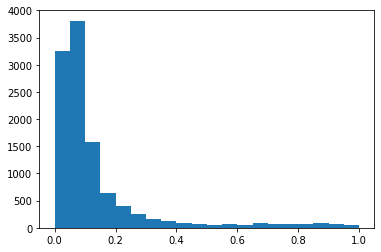

In [8]:
# Make a histogram of redshifts
q = "SELECT sn_z FROM mosthosts.mosthosts"
cursor.execute( q )
rows = cursor.fetchall()
zvals = np.array( [ row["sn_z"] for row in rows ] )
# fig,ax = pyplot.subplots()
pyplot.hist( zvals, range=(0,1), bins=20 )

In [9]:
# Associate the targetid from the public.secondary table.  There may be 
# clever way to do this all in SQL, but I'm banging it out in Python here.
# This is a little bit slow (but orders of magnitude faster than it was
# before I added the q3c index to public.secondary!).  It will update you
# every 1000 it completes; it takes 10-30 seconds to do each 1000.
cursor = dbconn.cursor()
q = "SELECT ra,dec,snname,sn_ra,sn_dec,sn_z,program,tns_name,iau_name,ptfiptf_name FROM mosthosts.mosthosts"
cursor.execute( q )
mosthosts = cursor.fetchall()
sys.stderr.write( f'Working on {len(mosthosts)} mosthosts...\n' )
radius = 1./3600.
nnone = 0
nmult = 0
none = 0
nmulttarget = 0
for i, row in enumerate(mosthosts):
    if (i%1000) == 0:
        sys.stderr.write( f"Did {i} of {len(mosthosts)}; nnone={nnone}, none={none}, nmult={nmult}, nmulttarget={nmulttarget}\n" ) 
    q = ( "SELECT ra,dec,targetid,program FROM public.secondary "
          "WHERE q3c_radial_query( ra, dec, %(ra)s, %(dec)s, %(radius)s ) "
          "   AND program='SN_HOSTS'" )
    # sys.stderr.write( f'Query: "{cursor.mogrify( q, { "ra": row["ra"], "dec": row["dec"], "radius": radius } )}"\n' )
    cursor.execute( q, { 'ra': row["ra"],
                         'dec': row['dec'],
                         'radius': radius } )
    matches = cursor.fetchall()
    if len(matches) == 0:
        for field in [ "targetid", "secondary_ra", "secondary_dec", "secondary_program" ]:
            row[field] = []
        nnone += 1
        sys.stderr.write( f'WARNING: {row["snname"]} had no entries in the secondary table\n' )
    else:
        if len(matches) > 1:
            # sys.stderr.write( f'{len(matches)} matches\n' )
            nmult += 1
        else:
            none += 1
        row["targetid"] = [ match["targetid"] for match in matches ]
        if len( set(row["targetid"]) ) > 1:
            nmulttarget += 1
        row["secondary_ra"] = [ match["ra"] for match in matches ]
        row["secondary_dec"] = [ match["dec"] for match in matches ]
        row["secondary_program"] = [ match["program"] for match in matches ]
print( f"{nnone} weren't found in the secondary table, {none} had one match, {nmult} had >1 match, {nmulttarget} had >1 targetid." )
        

Working on 20174 mosthosts...
Did 0 of 20174; nnone=0, none=0, nmult=0, nmulttarget=0
Did 1000 of 20174; nnone=0, none=0, nmult=1000, nmulttarget=96
Did 2000 of 20174; nnone=1, none=0, nmult=1999, nmulttarget=177
Did 3000 of 20174; nnone=1, none=0, nmult=2999, nmulttarget=276
Did 4000 of 20174; nnone=1, none=0, nmult=3999, nmulttarget=379
Did 5000 of 20174; nnone=1, none=0, nmult=4999, nmulttarget=491
Did 6000 of 20174; nnone=1, none=0, nmult=5999, nmulttarget=654
Did 7000 of 20174; nnone=1, none=0, nmult=6999, nmulttarget=820
Did 8000 of 20174; nnone=1, none=0, nmult=7999, nmulttarget=1000
Did 9000 of 20174; nnone=1, none=0, nmult=8999, nmulttarget=1145
Did 10000 of 20174; nnone=1, none=0, nmult=9999, nmulttarget=1276
Did 11000 of 20174; nnone=1, none=0, nmult=10999, nmulttarget=1374
Did 12000 of 20174; nnone=1, none=0, nmult=11999, nmulttarget=1457
Did 13000 of 20174; nnone=1, none=0, nmult=12999, nmulttarget=1562
Did 14000 of 20174; nnone=1, none=0, nmult=13999, nmulttarget=1607
Did

2 weren't found in the secondary table, 0 had one match, 20172 had >1 match, 2168 had >1 targetid.


At this point in the code, the variable "mosthosts" is a list, each element of the list being a dict corresponding to a row from the mosthosts table.  There are additional elements in each row:
* targetid : a list of DESI target ids found from the secondary table.  The same target id might show up more than once!  There are replicate target ids in the seconary table.
* secondary_ra : a list of RAs from the secondary table
* secondary_dec : a list of decs from the secondary table
* secondary_program  : a list of the "program"s from the secondary table
You can now perhaps do things with this, for example:

In [10]:
# Use the targetids we determined to suck in the redshifts 
# of the hosts from everest.zpix_redshifts
#
# nhist is going to be a histogram of number of 
# redshifts found in everest.zpix_redshifts for each
# entry in the mosthosts table.
#
# REMEMBER that sometimes the same SN shows up more than
# once in the mosthosts table!  Will need to take this
# into account when doing statistics later.
#
# This one takes a few seconds per 1000.  (It was *much* slower
# without an index.  If you ever make a postgres database,
# having the right indexes is important for search time.
# Of course, adding more indexes slows down insert time....

cursor = dbconn.cursor()
nhist = np.zeros( 11, dtype=int )
for i, row in enumerate(mosthosts):
    if (i%1000 == 0):
        sys.stderr.write( f'Did {i} of {len(mosthosts)}; {i-nhist[0]:d} have at least 1 match\n' )
    if len( row['targetid'] ) == 0:
        sys.stderr.write( f"Skipping {row['snname']}, it has no target ids\n" )
        continue
    q = ( "SELECT z,zerr,zwarn,spectype,subtype FROM everest.zpix_redshifts "
          "WHERE targetid in %s" )
    cursor.execute( q, ( tuple(row['targetid']), ) )
    matches = cursor.fetchall()
    if len(matches) == 0:
        nhist[0] += 1
        for field in ( 'z', 'zerr', 'zwarn', 'spectype', 'subtype' ):
            row['field'] = []
    else:
        if len(matches) >= 10:
            nhist[10] += 1
        else:
            nhist[ len(matches) ] += 1
        row['z'] = [ m['z'] for m in matches ]
        row['zerr'] = [ m['zerr'] for m in matches ]
        row['zwarn'] = [ m['zwarn'] for m in matches ]
        row['spectype'] = [ m['spectype'] for m in matches ]
        row['subtype'] = [ m['subtype'] for m in matches ]
sys.stderr.flush()
for i,val in enumerate(nhist):
    if i == 10:
        print( f'{val:5d} have {i:2d}+ matches' )
    else:
        print( f'{val:5d} have {i:2d} matches' )

Did 0 of 20174; 0 have at least 1 match
Did 1000 of 20174; 47 have at least 1 match
Skipping ZTF19aapocyd, it has no target ids
Did 2000 of 20174; 115 have at least 1 match
Did 3000 of 20174; 149 have at least 1 match
Did 4000 of 20174; 190 have at least 1 match
Did 5000 of 20174; 241 have at least 1 match
Did 6000 of 20174; 298 have at least 1 match
Did 7000 of 20174; 356 have at least 1 match
Did 8000 of 20174; 407 have at least 1 match
Did 9000 of 20174; 463 have at least 1 match
Did 10000 of 20174; 502 have at least 1 match
Did 11000 of 20174; 532 have at least 1 match
Did 12000 of 20174; 582 have at least 1 match
Did 13000 of 20174; 641 have at least 1 match
Did 14000 of 20174; 689 have at least 1 match
Did 15000 of 20174; 754 have at least 1 match
Did 16000 of 20174; 836 have at least 1 match
Skipping ZTF19aaqdrtb, it has no target ids
Did 17000 of 20174; 899 have at least 1 match
Did 18000 of 20174; 945 have at least 1 match
Did 19000 of 20174; 997 have at least 1 match
Did 2000

19144 have  0 matches
  998 have  1 matches
   29 have  2 matches
    0 have  3 matches
    1 have  4 matches
    0 have  5 matches
    0 have  6 matches
    0 have  7 matches
    0 have  8 matches
    0 have  9 matches
    0 have 10+ matches


In [11]:
# Figure out how many *independent* supernovae have matches, and get their zs
SNeWithZ = {}
for i,row in enumerate(mosthosts):
    if not 'z' in row:
        continue
    sn = row['snname']
    if len(row['z'])>0:
        if sn in SNeWithZ:
            SNeWithZ[sn]['z'].extend(row['z'])
            SNeWithZ[sn]['zerr'].extend(row['zerr'])
            SNeWithZ[sn]['zwarn'].extend(row['zwarn'])
            SNeWithZ[sn]['spectype'].extend(row['spectype'])
            SNeWithZ[sn]['subtype'].extend(row['subtype'])
            SNeWithZ[sn]['mosthostsdex'].append( i )
        else:
            SNeWithZ[sn] = {}
            SNeWithZ[sn]['z'] = list(row['z'])
            SNeWithZ[sn]['zerr'] = list(row['zerr'])
            SNeWithZ[sn]['zwarn'] = list(row['zwarn'])
            SNeWithZ[sn]['spectype'] = list(row['spectype'])
            SNeWithZ[sn]['subtype'] = list(row['subtype'])
            SNeWithZ[sn]['mosthostsdex'] = [ i ]
print( f'{len(SNeWithZ)} supernovae in the mosthosts lists have an everest redshift' )
# Turn the numerical values into numpy arrays for convenience
nnowarn = 0
for sn,row in SNeWithZ.items():
    row['z'] = np.array(row['z'])
    row['zerr'] = np.array(row['zerr'])
    row['numz'] = row['z'].size
    row['meanz'] = row['z'].mean()
    row['stdz'] = np.std(row['z'])
    znowarn = [ z for i,z in enumerate(row['z']) if row['zwarn'][i] == 0 ]
    zerrnowarn = [ zerr for i,zerr in enumerate(row['zerr']) if row['zwarn'][i] == 0 ]
    row['znowarn'] = np.array(znowarn)
    row['zerrnowarn'] = np.array(zerrnowarn)
    row['numznowarn'] = row['znowarn'].size
    if row['numznowarn'] > 0:
        row['meanznowarn'] = row['znowarn'].mean()
        row['stdznowarn'] = np.std(row['znowarn'])
    if len(row['znowarn']>0):
        nnowarn += 1
print( f'{nnowarn} supernovae in the mosthosts list have at least one everest redshift with zwarn=0' )

988 supernovae in the mosthosts lists have an everest redshift
951 supernovae in the mosthosts list have at least one everest redshift with zwarn=0


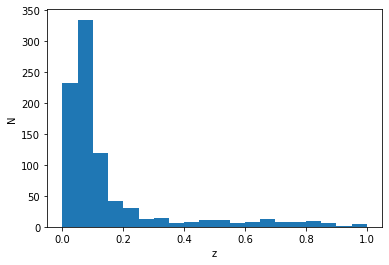

In [12]:
# Let's make a histogram of those zs
zvals = [ row['meanz'] for sn,row in SNeWithZ.items() ]
fig, ax = pyplot.subplots()
ax.hist( zvals, range=(0,1), bins=20)
ax.set_xlabel('z')
ax.set_ylabel('N')
fig.show()

len(zvals)=951


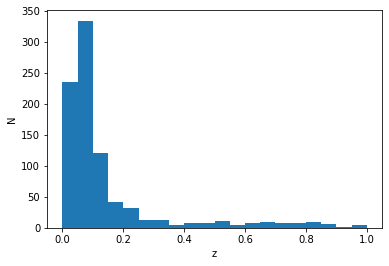

In [13]:
# Do a version omitting things with zwarn
zvals = [ row['meanznowarn'] for sn,row in SNeWithZ.items() if row['numznowarn']>0 ]
print( f'len(zvals)={len(zvals)}' )
fig, ax = pyplot.subplots()
ax.hist( zvals, range=(0,1), bins=20)
ax.set_xlabel('z')
ax.set_ylabel('N')
fig.show()

len(zvals)=800


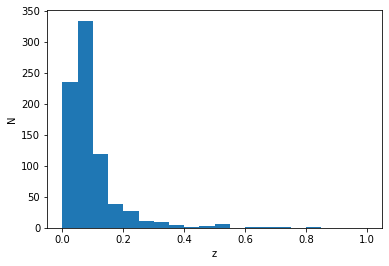

In [14]:
# Make another histogram omitting zwarn and things that are in the "Mat_QSO" program
zvals = [ row['meanznowarn'] for sn,row in SNeWithZ.items() 
          if ( row['numznowarn']>0 ) and ( "Mat_QSO" not in mosthosts[row['mosthostsdex'][0]]['program'] ) ]
print( f'len(zvals)={len(zvals)}' )
fig, ax = pyplot.subplots()
ax.hist( zvals, range=(0,1), bins=20)
ax.set_xlabel('z')
ax.set_ylabel('N')
fig.show()

In [15]:
# How many unique "program" strings from mosthosts does this represent?
programcount = {}
indivprogramcount = {}
nmosthostscount = np.zeros( 5, dtype=int )
for sn, row in SNeWithZ.items():
    n = len( row['mosthostsdex'] )
    if n >= 4:
        nmosthostscount[4] += 1
    else:
        nmosthostscount[n] += 1
    for i in row['mosthostsdex']:
        if mosthosts[i]['program'] in programcount:
            programcount[mosthosts[i]['program']] += 1
        else:
            programcount[mosthosts[i]['program']] = 1
        progs = mosthosts[i]['program'].split("/")
        for prog in progs:
            if prog in indivprogramcount:
                indivprogramcount[prog] += 1
            else:
                indivprogramcount[prog] = 1
print( 'Number of times a SN with DESI z is repeated in the mosthosts table:' )
for i, n in enumerate(nmosthostscount):
    print( f'{i:2d}   {n:4d}' )
print( '"program" values and how often they show up among SN with DESI z:' )
for program, count in programcount.items():
    print( f'{count:5d} {program}' )
print( 'How many times an individual program shows up among SN with DESI z (total count will be > # SN!)' )
for program, count in indivprogramcount.items():
    print( f'{count:5d} {program}' )

Number of times a SN with DESI z is repeated in the mosthosts table:
 0      0
 1    952
 2     32
 3      4
 4      0
"program" values and how often they show up among SN with DESI z:
  119 RCF/ZTFmarshal
    1 Anna/ZTFmarshal
   30 SNe_Ia/RCF
   15 SNe_Ia/ZTFmarshal
   86 SNe_Ia/RCF/ZTFmarshal
    4 RCF/IIps/ZTFmarshal
    1 SNe_Ia/IIps/ZTFmarshal
  117 SNe_Ia
   56 RCF
   67 historical_SNIa
    1 SNe_Ia/RCF/IIps/ZTFmarshal
  156 Mat_QSO
    2 IIps/PTF-iPTF
   21 search_selection
    2 IIps/ZTFmarshal
    9 Rubin_cosmoSNIa
    1 IIps
   38 SDSS_II
  223 PTF-iPTF
   79 ZTFmarshal
How many times an individual program shows up among SN with DESI z (total count will be > # SN!)
  296 RCF
  308 ZTFmarshal
    1 Anna
  250 SNe_Ia
   11 IIps
   67 historical_SNIa
  156 Mat_QSO
  225 PTF-iPTF
   21 search_selection
    9 Rubin_cosmoSNIa
   38 SDSS_II


And now for something different.  It's *possible* that there are DESI target IDs associated with galaxies inthe mosthosts table that are NOT in the secondary table under the SN_HOSTS program.  DESI will sometimes have multiple target ids for the same galaxy.  Some of the galaxies we care about might be in the BGS, which may well have a targetid that doesn't match the same galaxy's targetid in secondary.  So... let's forget about the secondary table for a bit, and do a straight-up RA/DEC search of the everest table.

In [29]:
# Search the everest zpix_redshfits table for things with 1" of the
#  RA/DEC in the mosthosts table.
# I'm doing this a big different from how I did the last one.  Instead of
#  making a new varaible like SNeWithZ, I'm just going to add more fields
#  to the mosthosts table.
cursor = dbconn.cursor()
nhist = np.zeros( 11, dtype=int )
nhistnowarn = np.zeros( 11, dtype=int )
for i, row in enumerate(mosthosts):
    if (i%1000 == 0):
        sys.stderr.write( f'Did {i} of {len(mosthosts)}; {i-nhist[0]:d} have at least 1 match\n' )
    q = ( "SELECT targetid,z,zerr,zwarn,spectype,subtype FROM everest.zpix_redshifts "
          "WHERE q3c_radial_query(target_ra,target_dec,%s,%s,1./3600)" )
    cursor.execute( q, ( row['ra'], row['dec'] ) )
    matches = cursor.fetchall()
    n = len(matches)
    for field in [ 'targetid', 'z', 'zerr', 'zwarn', 'spectype', 'subtype' ]:
        row[f'zpix_{field}'] = [ match[field] for match in matches ]
        row[f'zpix_nowarn_{field}'] = [ match[field] for match in matches if match['zwarn']==0 ]
    nnowarn = len(row['zpix_nowarn_targetid'])
    if n >= 10:
        nhist[10] += 1
    else:
        nhist[n] += 1
    if nnowarn >= 10:
        nhistnowarn[10] += 1
    else:
        nhistnowarn[nnowarn] += 1



Did 0 of 20174; 0 have at least 1 match
Did 1000 of 20174; 56 have at least 1 match
Did 2000 of 20174; 133 have at least 1 match
Did 3000 of 20174; 171 have at least 1 match
Did 4000 of 20174; 212 have at least 1 match
Did 5000 of 20174; 268 have at least 1 match
Did 6000 of 20174; 330 have at least 1 match
Did 7000 of 20174; 391 have at least 1 match
Did 8000 of 20174; 453 have at least 1 match
Did 9000 of 20174; 512 have at least 1 match
Did 10000 of 20174; 557 have at least 1 match
Did 11000 of 20174; 591 have at least 1 match
Did 12000 of 20174; 645 have at least 1 match
Did 13000 of 20174; 707 have at least 1 match
Did 14000 of 20174; 755 have at least 1 match
Did 15000 of 20174; 823 have at least 1 match
Did 16000 of 20174; 910 have at least 1 match
Did 17000 of 20174; 982 have at least 1 match
Did 18000 of 20174; 1032 have at least 1 match
Did 19000 of 20174; 1091 have at least 1 match
Did 20000 of 20174; 1130 have at least 1 match


In [30]:
print( "Result of matching mosthosts ra/dec to everest.zpix_redshifts:" )
print( "Left: number of rows in everest.zpix_redshifts that matched a mosthosts entry; "
       "Right: number of mosthosts rows with this many matches from everest." )
for i, n in enumerate( nhist ):
    if i == 10:
        print( f'≥10  {n:5d}' )
    else:
        print( f'{i:3d}  {n:5d}' )
print( "Same thing, only including zwarn=0" )
for i, n in enumerate( nhistnowarn ):
    if i == 10:
        print( f'≥10  {n:5d}' )
    else:
        print( f'{i:3d}  {n:5d}' )

Result of matching mosthosts ra/dec to everest.zpix_redshifts:
Left: number of rows in everest.zpix_redshifts that matched a mosthosts entry; Right: number of mosthosts rows with this many matches from everest.
  0  19043
  1   1073
  2     55
  3      1
  4      2
  5      0
  6      0
  7      0
  8      0
  9      0
≥10      0
Same thing, only including zwarn=0
  0  19090
  1   1033
  2     48
  3      1
  4      2
  5      0
  6      0
  7      0
  8      0
  9      0
≥10      0


In [53]:
# There will be duplicates in this.  The different everest targetids that have the same RA/DEC are
#  already accounted for in the statistics above.  However, there's also the issue that the mosthosts
#  table has multiple entries for the same SN RA/DEC.  Previously, I searched in supernova name, but to
#  be safe, we really ought to search on RA/DEC.  Time for another messy data structure.
# First, though, a double for loop in python would take bloody forever, so do some numpy stuff.
# (I still have a slow for loop, but at least it's not n²-in-python slow.)

snra = np.array( [ host['sn_ra'] for host in mosthosts ] )
sndec = np.array( [ host['sn_dec'] for host in mosthosts ] )
sncoord = SkyCoord( snra, sndec, unit='deg' )

indepmosthosts = []
alreadyfound = np.repeat( False, len(mosthosts) )
for i, host in enumerate(mosthosts):
    if (i%1000==0):
        print( f'Done {i} of {len(mosthosts)}...' )
    dist = sncoord[i].separation( sncoord ).to( units.arcsec ).value
    w = np.where( ( ( dist <= 1. ) & ( ~alreadyfound ) ) )[0]
    if w.size > 0:
        alreadyfound[w] = True
        indepmosthosts.append( [ mosthosts[j] for j in w ] )
print( f'{len(indepmosthosts)} independent SNe in MostHosts' )


Done 0 of 20174...
Done 1000 of 20174...
Done 2000 of 20174...
Done 3000 of 20174...
Done 4000 of 20174...
Done 5000 of 20174...
Done 6000 of 20174...
Done 7000 of 20174...
Done 8000 of 20174...
Done 9000 of 20174...
Done 10000 of 20174...
Done 11000 of 20174...
Done 12000 of 20174...
Done 13000 of 20174...
Done 14000 of 20174...
Done 15000 of 20174...
Done 16000 of 20174...
Done 17000 of 20174...
Done 18000 of 20174...
Done 19000 of 20174...
Done 20000 of 20174...
14812 independent SNe in MostHosts


In [54]:

# Count how many have everest values
neverest = 0
nnowarneverest = 0
neverestnoqso = 0
nnowarneverestnoqso = 0
for indep in indepmosthosts:
    havezpix = False
    havenowarn = False
    qso = False
    for host in indep:
        if len( host['zpix_targetid']) > 0: havezpix = True
        if len( host['zpix_nowarn_targetid']) > 0: havenowarn = True
        if host['program'] == "Mat_QSO": qso = True
    if havezpix:
        neverest += 1
        if not qso: neverestnoqso += 1
    if havenowarn:
        nnowarneverest += 1
        if not qso: nnowarneverestnoqso += 1
print( f'{neverest} have at least one of their possible hosts observed by everest;\n'
       f'{nnowarneverest} have at least one with zwarn=0' )
print( f'Omitting Mat_QSO, {neverestnoqso}, or {nnowarneverestnoqso} with zwarn=0' )

1070 have at least one of their possible hosts observed by everest;
1035 have at least one with zwarn=0
Omitting Mat_QSO, 904, or 874 with zwarn=0
